# Imports

In [1]:
from dataclasses import dataclass
from pathlib import Path
import pandas as pd
from datetime import datetime
import numpy as np
import random
import seaborn as sns
from typing import Optional, Tuple, Union
import matplotlib.pyplot as plt
from syntheval import SynthEval
from tqdm.notebook import tqdm  # für Jupyter kompatibel
from concurrent.futures import ThreadPoolExecutor, as_completed

# User Settings

In [2]:
@dataclass
class Config:
    data_dir: Path = Path("../../data")
    figures_dir: Path = Path("figures")
    results_dir: Path = Path("results")

    real_file: str = "20250301_data_20250510_122405_final_100_train.csv"
    synth_file: str = "20250301_data_20250510_122405_final_100_synth.csv"
    holdout_file: str = "20250301_data_20250510_122405_final_100_holdout.csv"

    random_seed: int = 42
    bootstrap_sizes = [100, 500, 1000, 2000, 3500, 5000, 7500, 10000]
    # bootstrap_sizes = [100, 200, 500] # Debug
    # bootstrap_sizes = [100, 1000, 2000] # Debug
    n_bootstrap = 30
    thres = 0.075  # 1/30=0.0333 ist Standardwert wie in SynthEval

    save_data: bool = True

# Set my design
sns.set_theme(
    style="white",
    context="paper",
    palette="colorblind",
    rc={
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial"],
        "font.size": 7,
        "axes.titlesize": 7,
        "axes.labelsize": 7,
        "xtick.labelsize": 7,
        "ytick.labelsize": 7,
        "legend.fontsize": 7
    }
)


# Utility Functions

In [3]:
def convert_dtypes(df: pd.DataFrame) -> pd.DataFrame:
    """
    Konvertiert bestimmte Spalten des DataFrames in die gewünschten Datentypen:
     - definierte Spalten als category
     - definierte Spalten als pandas Nullable Integer (Int64)
     - consciousness_level und news_score als geordnete Categoricals
    """
    df = df.copy()  # Änderungen nicht am Original vornehmen

    # 1) Kategorische Spalten
    cat_cols = ['gender', 'ethnicity', 'chief_complaint', 'icd_block']
    for col in cat_cols:
        # df[col] = df[col].astype('category')
        df[col] = df[col].astype('object') # 'category' führt zu Problemen mit dem OneHotEncoder

    # 2) Integer-Spalten mit Nullable Integer dtype
    int_cols = ['age', 'systolic_bp', 'diastolic_bp',
                'heart_rate', 'respiratory_rate', 'oxygen_saturation']
    for col in int_cols:
        df[col] = df[col].astype('Int64')
        # df[col] = df[col].astype('int32')

    # 3) Geordnete Categoricals
    df['consciousness_level'] = pd.Categorical(
        df['consciousness_level'],
        categories=['A', 'C', 'V', 'P', 'U'],
        ordered=True
    )
    df['news_score'] = pd.Categorical(
        df['news_score'],
        categories=list(range(19)),
        ordered=True
    )

    return df

def load_data(
    real_filename: Union[str, Path],
    synth_filename: Optional[Union[str, Path]] = None,
    holdout_filename: Optional[Union[str, Path]] = None,
    data_dir: Path = None,
) -> Tuple[pd.DataFrame, Optional[pd.DataFrame], Optional[pd.DataFrame]]:
    """
    Lädt die realen, synthetischen und optionalen Holdout-CSV-Dateien
    aus data_dir und wandelt sie über convert_dtypes um.

    Returns:
        df_real: pd.DataFrame
        df_synth: Optional[pd.DataFrame]
        df_holdout: Optional[pd.DataFrame]
    """
    def _read_and_convert(fn: Union[str, Path]) -> pd.DataFrame:
        return (
            pd.read_csv(data_dir / fn, low_memory=False)
              .pipe(convert_dtypes)
        )

    df_real    = _read_and_convert(real_filename)
    df_synth   = _read_and_convert(synth_filename)   if synth_filename   else None
    df_holdout = _read_and_convert(holdout_filename) if holdout_filename else None

    return df_real, df_synth, df_holdout

# Main Routine
## Data Import

In [4]:
cfg = Config()
current_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

df_train, df_synth, df_holdout = load_data(
    cfg.real_file,
    cfg.synth_file,
    cfg.holdout_file,
    data_dir=cfg.data_dir
)

df_holdout = df_holdout.dropna().reset_index(drop=True)

In [5]:
target_col = 'icu_admission_24h'
num_cols = ['age', 'temperature', 'heart_rate', 'respiratory_rate', 'oxygen_saturation', 'systolic_bp', 'diastolic_bp']
cat_cols = ['gender', 'ethnicity', 'chief_complaint', 'icd_block', 'night_arrival', 'weekend_arrival']
ord_cols = ['consciousness_level','news_score']
bool_cols = ['night_arrival', 'weekend_arrival']

cat_ord_cols = cat_cols + ord_cols
cat_ord_cols.append(target_col)
print(cat_ord_cols)

['gender', 'ethnicity', 'chief_complaint', 'icd_block', 'night_arrival', 'weekend_arrival', 'consciousness_level', 'news_score', 'icu_admission_24h']


In [6]:
# df_train_sampled = df_train.sample(n=100, random_state=cfg.random_seed, replace=False)
# df_synth_sampled = df_synth.sample(n=100, random_state=cfg.random_seed, replace=False)

# Train_vs_Synth = SynthEval(real_dataframe=df_train_sampled, cat_cols=cat_ord_cols, verbose=False)
# res = Train_vs_Synth.evaluate(df_synth_sampled, hit_rate={'thres_percent': cfg.thres})
# val = res.loc[res['metric']=='hit_rate', 'val'].iloc[0]

In [7]:
# print(res)

## Stabilitätsanalyse
Aktuell formal noch kein Bootstrap, daher Replacement ausgeschaltet. Hier geht es um konstante Stichprobengröße ohne Verzerrung durch Mehrfachziehungen, daher Subsampling.
Echtes Bootstrap (mit Replacement) kommt später bei der Fehlerintervall-Berechnung.

### bootstrap_size

Parallelisierung

In [ ]:
def hitting_rate_job(args):
    bsize, boot = args
    df_train_sampled = df_train.sample(n=bsize, random_state=cfg.random_seed + boot, replace=False)
    df_synth_sampled = df_synth.sample(n=bsize, random_state=cfg.random_seed + boot, replace=False)
    Train_vs_Synth = SynthEval(real_dataframe=df_train_sampled, cat_cols=cat_ord_cols, verbose=False)
    res = Train_vs_Synth.evaluate(df_synth_sampled, hit_rate={'thres_percent': cfg.thres})
    val = res.loc[res['metric']=='hit_rate', 'val'].iloc[0]
    return {'sample_size': bsize, 'bootstrap': boot, 'val': val}


In [ ]:
# Aufgabenliste erstellen
all_tasks = [(bsize, boot)
             for bsize in cfg.bootstrap_sizes
             for boot in range(cfg.n_bootstrap)]

results = []
with ThreadPoolExecutor(max_workers=12) as executor:  # Passe max_workers ggf. an
    futures = [executor.submit(hitting_rate_job, task) for task in all_tasks]
    for f in tqdm(as_completed(futures), total=len(futures), desc='Bootstraps (Threads)'):
        results.append(f.result())

Ohne Parallelisierung

In [ ]:
# results = []

# for bsize in tqdm(cfg.bootstrap_sizes, desc='Sample Size'):
#     # for boot in range(cfg.n_bootstrap):
#     for boot in tqdm(range(cfg.n_bootstrap), desc='Bootstrap', leave=False, position=1):
#         # Sampling (ohne replacement)
#         df_train_sampled = df_train.sample(n=bsize, random_state=cfg.random_seed + boot, replace=False)
#         df_synth_sampled = df_synth.sample(n=bsize, random_state=cfg.random_seed + boot, replace=False)

#         # Hitting-Rate berechnen
#         Train_vs_Synth = SynthEval(real_dataframe=df_train_sampled, cat_cols=cat_ord_cols, verbose=False)
#         res = Train_vs_Synth.evaluate(df_synth_sampled, hit_rate={'thres_percent': cfg.thres})
#         val = res.loc[res['metric']=='hit_rate', 'val'].iloc[0]
#         results.append({
#             'sample_size': bsize,
#             'bootstrap': boot,
#             'val': val
#         })

#### save results

In [ ]:
df_bootstrap = pd.DataFrame(results)
if cfg.save_data:
    df_bootstrap.to_csv(cfg.results_dir / f"bootstrap_size-test_n-{cfg.n_bootstrap}_tresh-{cfg.thres}_{current_timestamp}.csv", index=False, header=True, decimal=',', sep=';', encoding='utf-8')
    print(f"Bootstrap results saved to {cfg.results_dir / f'bootstrap_size-test_n-{cfg.n_bootstrap}_tresh-{cfg.thres}_{current_timestamp}.csv'}")
# display(df_bootstrap)

#### load instead

In [51]:
df_bootstrap = pd.read_csv(cfg.results_dir / f"bootstrap_size-test_n-30_tresh-0.075_20250515_162051.csv", sep=';', decimal=',')

In [52]:
summary = df_bootstrap.groupby(['sample_size'])['val'].agg(['mean', 'std']).reset_index()
print(summary)

   sample_size      mean       std
0          100  0.000000  0.000000
1          500  0.000000  0.000000
2         1000  0.000000  0.000000
3         2000  0.000167  0.000273
4         3500  0.000467  0.000379
5         5000  0.000860  0.000404
6         7500  0.001542  0.000596
7        10000  0.002337  0.000528


Abbildung gespeichert unter: figures\bootstrap_size-test_n-30_thresh-0.075_20250601_144055.tiff


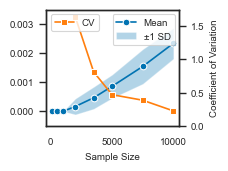

In [53]:
# Berechne CV
summary['cv'] = summary['std'] / summary['mean']

plt.figure(figsize=(2.3, 1.725))
ax1 = plt.gca()

# Mean und ±1 std
sns.lineplot(data=summary, x='sample_size', y='mean', marker='o', label='Mean', ax=ax1)
ax1.fill_between(summary['sample_size'], 
                 summary['mean'] - summary['std'], 
                 summary['mean'] + summary['std'], 
                 alpha=0.3, label='±1 SD')
ax1.set_xlabel('Sample Size')
# ax1.set_ylabel('Hitting Rate')
ax1.set_ylabel('')
ax1.set_ylim(-0.0005, 0.0035)
ax1.legend(loc='upper right')

# Zweite y-Achse für CV
ax2 = ax1.twinx()
sns.lineplot(data=summary, x='sample_size', y='cv', marker='s', color='tab:orange', label='CV', ax=ax2)
ax2.set_ylabel('Coefficient of Variation')
ax2.set_ylim(0, 1.75)
ax2.legend(loc='upper left')

# plt.title('Stabilität der Hitting-Rate in Abhängigkeit der Sample-Size')
plt.tight_layout()

if cfg.save_data:
    fname = f'bootstrap_size-test_n-{cfg.n_bootstrap}_thresh-{cfg.thres}_{current_timestamp}.tiff'
    fullpath = cfg.figures_dir / fname
    plt.savefig(
        fullpath,
        dpi=300,
        format='tiff',
        bbox_inches='tight',
        pil_kwargs={'compression': 'tiff_lzw'}
    )
    print(f"Abbildung gespeichert unter: {fullpath}")

plt.show()


### n_bootstraps

In [11]:
bootstrap_size = 5000
# n_bootstrap_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
n_bootstrap_list = [10, 30, 50]

In [12]:
all_tasks = [(n_boot, boot)
             for n_boot in n_bootstrap_list
             for boot in range(n_boot)]

In [13]:
def hitting_rate_job(args):
    n_boot, boot = args
    df_train_sampled = df_train.sample(n=bootstrap_size, random_state=cfg.random_seed + boot, replace=False)
    df_synth_sampled = df_synth.sample(n=bootstrap_size, random_state=cfg.random_seed + boot, replace=False)
    Train_vs_Synth = SynthEval(real_dataframe=df_train_sampled, cat_cols=cat_ord_cols, verbose=False)
    res = Train_vs_Synth.evaluate(df_synth_sampled, hit_rate={'thres_percent': cfg.thres})
    val = res.loc[res['metric']=='hit_rate', 'val'].iloc[0]
    return {'n_bootstrap': n_boot, 'bootstrap': boot, 'val': val}


In [14]:
results_n_bootstraps = []
with ThreadPoolExecutor(max_workers=12) as executor:
    futures = [executor.submit(hitting_rate_job, task) for task in all_tasks]
    for f in tqdm(as_completed(futures), total=len(futures), desc='Bootstraps (Threads)'):
        results_n_bootstraps.append(f.result())


Bootstraps (Threads):   0%|          | 0/90 [00:00<?, ?it/s]

In [15]:
df_bootstrap_n_bootstraps = pd.DataFrame(results_n_bootstraps)


In [16]:
summary_n_bootstraps = df_bootstrap_n_bootstraps.groupby(['n_bootstrap'])['val'].agg(['mean', 'std']).reset_index()

#### save

In [17]:
print(summary_n_bootstraps)
if cfg.save_data:
    summary_n_bootstraps.to_csv(cfg.results_dir / f"hitting-rate_n_bootstrap-finding_s-{bootstrap_size}_tresh-{cfg.thres}_{current_timestamp}.csv", index=False, header=True, decimal=',', sep=';', encoding='utf-8')
    print(f"Bootstrap results saved to {cfg.results_dir / f'hitting-rate_n_bootstrap-finding_s-{bootstrap_size}_tresh-{cfg.thres}_{current_timestamp}.csv'}")

   n_bootstrap      mean       std
0           10  0.000940  0.000453
1           30  0.000860  0.000404
2           50  0.000784  0.000402
Bootstrap results saved to results\hitting-rate_n_bootstrap-finding_s-5000_tresh-0.075_20250601_144055.csv


#### load instead

In [ ]:
summary_n_bootstraps = pd.read_csv(cfg.results_dir / f"hitting-rate_n_bootstrap-finding_s-5000_tresh-0.075_20250601_144055.csv", sep=';', decimal=',')

Abbildung gespeichert unter: figures\hitting-rate_n_bootstrap-finding_s-5000_tresh-0.075_20250601_144055.tiff


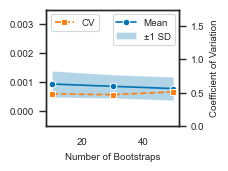

In [67]:
# CV berechnen
summary_n_bootstraps['cv'] = summary_n_bootstraps['std'] / summary_n_bootstraps['mean']

plt.figure(figsize=(2.3, 1.725))
ax1 = plt.gca()

# Mean und ±1 std
sns.lineplot(data=summary_n_bootstraps, x='n_bootstrap', y='mean', marker='o', label='Mean', ax=ax1)
plt.fill_between(summary_n_bootstraps['n_bootstrap'],
                 summary_n_bootstraps['mean'] - summary_n_bootstraps['std'],
                 summary_n_bootstraps['mean'] + summary_n_bootstraps['std'],
                 alpha=0.3, label='±1 SD')
ax1.set_xlabel('Number of Bootstraps')
ax1.set_ylabel('')
# ax1.set_ylabel('Hitting Rate')
# ax1.set_ylim(0.00025, 0.002)
ax1.set_ylim(-0.0005, 0.0035)
ax1.legend(loc='upper right')

# CV als zweite Linie
ax2 = ax1.twinx()
sns.lineplot(data=summary_n_bootstraps, x='n_bootstrap', y='cv', marker='s', linestyle='--', label='CV', ax=ax2, color='tab:orange')
ax2.set_ylabel('Coefficient of Variation')
# ax2.set_ylim(0.4, 0.6)
ax2.set_ylim(0, 1.75)
ax2.legend(loc='upper left')

plt.tight_layout()

if cfg.save_data:
    fname = f'hitting-rate_n_bootstrap-finding_s-{bootstrap_size}_tresh-{cfg.thres}_{current_timestamp}.tiff'
    fullpath = cfg.figures_dir / f'{fname}'
    plt.savefig(
        fullpath,
        dpi=300,
        format='tiff',
        bbox_inches='tight',
        pil_kwargs={'compression': 'tiff_lzw'}
    )
    print(f"Abbildung gespeichert unter: {fullpath}")
plt.show()



## thresh_percent Bestimmung

In [38]:
thres_grid = np.linspace(0, 0.1, 21) # 0%, 0.5%, 1%, 1.5%, ..., 10%
thres_grid_coarse = np.linspace(0, 0.1, 11)  # 0%, 1%, …, 10%
thres_grid_fine = np.linspace(0.045, 0.055, 11)  # 0%, 1%, …, 10%

bootstrap_size = 5000
n_bootstrap = 30

In [ ]:
for thres in tqdm(thres_grid_fine, desc="thres_percent"):
    for boot in tqdm(range(n_bootstrap), desc="Bootstrap", leave=False, position=1):
        # Sample jeweils 5000 aus Train, Holdout, Synth
        tr_sample = df_train.sample(bootstrap_size, replace=False, random_state=cfg.random_seed + boot)
        ho_sample = df_holdout.sample(bootstrap_size, replace=False, random_state=cfg.random_seed + boot)
        sy_sample = df_synth.sample(bootstrap_size, replace=False, random_state=cfg.random_seed + boot)

        # Train vs. Synth
        Train_vs_Synth = SynthEval(real_dataframe=tr_sample, cat_cols=cat_ord_cols, verbose=False)
        res_tr = Train_vs_Synth.evaluate(sy_sample, hit_rate={'thres_percent': thres})
        hr_train = res_tr.loc[res_tr['metric']=='hit_rate', 'val'].iloc[0]

        # Holdout vs. Synth
        Holdout_vs_Synth = SynthEval(real_dataframe=ho_sample, cat_cols=cat_ord_cols, verbose=False)
        res_ho = Holdout_vs_Synth.evaluate(sy_sample, hit_rate={'thres_percent': thres})
        hr_hold = res_ho.loc[res_ho['metric']=='hit_rate', 'val'].iloc[0]

        results.append({'thres': thres, 'bootstrap': boot,
                        'hr_train': hr_train, 'hr_hold': hr_hold})

In [ ]:
df_res = pd.DataFrame(results)



### save res

In [ ]:
if cfg.save_data:
    fname = f"hitting-rate_thresh-finding_fine_s-5000_n30_{current_timestamp}.csv"
    df_res.to_csv(cfg.results_dir / fname, index=False, header=True, decimal=',', sep=';', encoding='utf-8')
    print(f"Bootstrap results saved to {cfg.results_dir / fname}")

### load instead

In [56]:
df_res = pd.read_csv(cfg.results_dir / f"hitting-rate_thresh-finding_fine_s-5000_n30_20250515_162051.csv", sep=';', decimal=',')

In [57]:
summary = df_res.groupby('thres').agg(
    hr_train_mean = ('hr_train', 'mean'),
    hr_train_se   = ('hr_train', 'sem'),
    hr_hold_mean  = ('hr_hold', 'mean'),
    hr_hold_se    = ('hr_hold', 'sem'),
).reset_index()

summary['privacy_gap'] = summary['hr_train_mean'] - summary['hr_hold_mean']
print(summary)

    thres  hr_train_mean  hr_train_se  hr_hold_mean  hr_hold_se  privacy_gap
0   0.000       0.000000     0.000000      0.000000    0.000000     0.000000
1   0.010       0.000000     0.000000      0.000000    0.000000     0.000000
2   0.020       0.000000     0.000000      0.000000    0.000000     0.000000
3   0.030       0.000000     0.000000      0.000000    0.000000     0.000000
4   0.040       0.000007     0.000007      0.000007    0.000007     0.000000
5   0.045       0.000033     0.000014      0.000027    0.000013     0.000007
6   0.046       0.000047     0.000016      0.000040    0.000015     0.000007
7   0.047       0.000047     0.000016      0.000040    0.000015     0.000007
8   0.048       0.000060     0.000024      0.000040    0.000015     0.000020
9   0.049       0.000073     0.000026      0.000053    0.000016     0.000020
10  0.050       0.000093     0.000019      0.000060    0.000012     0.000033
11  0.051       0.000093     0.000027      0.000073    0.000020     0.000020

Abbildung gespeichert unter: figures\hitting-rate_thresh-finding_fine_s-5000_n30_20250601_144055.tiff


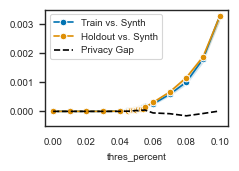

In [66]:
fig, ax = plt.subplots(figsize=(2.4, 1.725))

# Hitting-Rate Kurven mit Fehlerbändern
sns.lineplot(ax=ax, data=summary, x='thres', y='hr_train_mean', marker='o', label='Train vs. Synth')
sns.lineplot(ax=ax, data=summary, x='thres', y='hr_hold_mean', marker='o', label='Holdout vs. Synth')
ax.fill_between(summary['thres'],
                 summary['hr_train_mean'] - summary['hr_train_se'],
                 summary['hr_train_mean'] + summary['hr_train_se'],
                 alpha=0.2)
ax.fill_between(summary['thres'],
                 summary['hr_hold_mean'] - summary['hr_hold_se'],
                 summary['hr_hold_mean'] + summary['hr_hold_se'],
                 alpha=0.2)

# Privacy-Gap als eigene Kurve
sns.lineplot(ax=ax, data=summary, x='thres', y='privacy_gap', color='black', linestyle='--', label='Privacy Gap')

ax.set_xlabel('thres_percent')
# plt.ylabel('Hitting Rate')
ax.set_ylabel('')
ax.set_ylim(-0.0005, 0.0035)
# plt.title('Hitting-Rate Sensitivitätsanalyse mit Bootstrapping')

ax.yaxis.set_ticks_position('left')
ax.tick_params(
    axis='y',
    which='both',
    left=True,       # draw ticks on the left
    right=False,     # (optional) disable ticks on the right
    labelleft=True,  # show tick labels on the left
    length=4,
    width=1,
    direction='out'
)

ax.legend()
plt.tight_layout()
if cfg.save_data:
    fname = f'hitting-rate_thresh-finding_fine_s-5000_n30_{current_timestamp}.tiff'
    fullpath = cfg.figures_dir / f'{fname}'
    plt.savefig(
        fullpath,
        dpi=300,
        format='tiff',
        bbox_inches='tight',
        pil_kwargs={'compression': 'tiff_lzw'}
    )
    print(f"Abbildung gespeichert unter: {fullpath}")
plt.show()